In [9]:
import numpy as np
import matplotlib
import pandas as pd

dataset = pd.read_csv('/Users/wzhang/Downloads/lake_erie_habs_W4_6_8_9_12_13_16_2013-2020.xlsx - HAB_data (1).csv')

train = dataset.iloc[:743,:]
test = dataset.iloc[743:,:]
print(train)
print(test)
X_train = pd.DataFrame(train.iloc[:,4:15].values)
Y_train = train.iloc[:,16:].values
print(X_train.shape)
print(Y_train.shape)
X_test = pd.DataFrame(test.iloc[:,4:15].values)
Y_test = test.iloc[:,16:].values
print(X_test.shape)
print(Y_test.shape)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


          Date  Site  Latitude (decimal deg)  Longitude (decimal deg)  \
0    5/29/2013   WE6                 41.7134                 -83.3804   
1    5/29/2013   WE8                 41.8343                 -83.3633   
2    5/29/2013   WE4                 41.8267                 -83.1930   
3    6/10/2013   WE6                 41.7144                 -83.3805   
4    6/10/2013   WE8                 41.8353                 -83.3631   
..         ...   ...                     ...                      ...   
738  10/7/2019  WE16                 41.6599                 -83.1467   
739  10/7/2019  WE13                 41.7428                 -83.1354   
740  10/7/2019  WE12                 41.7023                 -83.2639   
741  10/7/2019   WE4                 41.8270                 -83.1949   
742  6/16/2020   WE6                 41.7054                 -83.3864   

     Secchi Depth (m)  CTD Temperature (°C)  \
0                1.60                  18.5   
1                1.00        

In [10]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor

In [11]:
# Initialize MLP model
def create_mlp():
    mlp_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)  # Output layer for regression task
    ])

    # Compile the model
    mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='mae')

    # Print model summary
    mlp_model.summary()

    # Train the model
    history = mlp_model.fit(X_train, Y_train, epochs=2000, batch_size=32, validation_split=0.2)

    # Evaluate model performance
    Y_pred = mlp_model.predict(X_test)
    return mlp_model


In [12]:
def create_rf():
    # Initialize Random Forest regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, Y_train)
    return rf_model


In [13]:
import lightgbm as lgb
def create_lightgbm():
    params = { 
    'objective': 'regression', 
    'metric': 'rmse', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9, 
    }
    train_data = lgb.Dataset(X_train,label=Y_train)
    num_round = 100
    bst = lgb.train(params, train_data, num_round) 
    from sklearn.metrics import mean_squared_error as mse 
    from lightgbm import LGBMRegressor 
    
    # Create an instance of the LightGBM Regressor with the RMSE metric. 
    model = LGBMRegressor(metric='rmse') 
    
    # Train the model using the training data. 
    model.fit(X_train, Y_train) 

    res = model.predict(X_test) 
    return model


In [14]:
from sklearn.svm import SVR
def create_SVM():
    # Initialize SVM regressor
    svm_model = SVR(kernel='rbf', C=10000, gamma='scale')

    # Train the model
    svm_model.fit(X_train, Y_train)
    return svm_model


In [15]:
from tensorflow.keras.layers import concatenate

In [16]:
mlp = create_mlp()
lightgbm = create_lightgbm()
mlpPredict = mlp.predict(X_train)
lightgbmPredict = lightgbm.predict(X_train)
mlpPredict.resize(743,1)
lightgbmPredict.resize(743,1)
trainData = concatenate([mlpPredict, lightgbmPredict])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 33.4499 - val_loss: 31.6451
Epoch 2/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.8266 - val_loss: 30.7019
Epoch 3/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.7008 - val_loss: 28.4556
Epoch 4/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.7222 - val_loss: 25.5908
Epoch 5/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.4619 - val_loss: 23.8932
Epoch 6/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.8323 - val_loss: 23.4475
Epoch 7/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.5658 - val_loss: 23.2873
Epoch 8/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.9688 - val_loss: 23.1662
Epoch 9/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.3547 - val_loss: 22.9010
Epoch 10/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.9030 - val_loss: 22.4801
Epoch 11/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.4640 - val_loss: 22.0612
Epoch 12/2000
19/19 ━━━━━━━━━

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
regressor = AdaBoostRegressor(n_estimators=100, learning_rate=1.0, random_state=0)
regressor.fit(trainData, Y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(learning_rate=1.0, max_depth=1, random_state=0)

In [ ]:
mlpPredictTest = mlp.predict(X_test)
ligthgbmPredictTest = lightgbm.predict(X_test)
ligthgbmPredictTest.resize(96,1)
mlpPredictTest.resize(96,1)
testData = concatenate([mlpPredictTest,ligthgbmPredictTest])
print(testData)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
tf.Tensor(
[[ 6.5107355  5.7270894]
 [41.893257  20.880665 ]
 [ 5.303425   5.3784695]
 [ 8.253113   3.438314 ]
 [ 5.1773252 -7.8666725]
 [32.79471   15.524524 ]
 [17.128876  11.082302 ]
 [11.683435   8.423869 ]
 [13.661304  10.429737 ]
 [35.92815   17.36928  ]
 [ 4.3900843  3.8410964]
 [24.595081  32.46145  ]
 [16.110474  11.589534 ]
 [44.33493   24.122145 ]
 [ 7.5730896  6.505051 ]
 [44.17323   57.64031  ]
 [12.33381   10.402997 ]
 [36.861855  49.31299  ]
 [11.795148  12.235443 ]
 [31.85165   33.425198 ]
 [14.734669  12.814556 ]
 [47.888145  61.878006 ]
 [ 9.001422   4.1939807]
 [18.014767   9.833982 ]
 [11.40646   11.036034 ]
 [15.482931  13.867103 ]
 [59.86991   64.908806 ]
 [20.150772  19.327457 ]
 [65.348495  63.75182  ]
 [ 9.521138  10.95908  ]
 [18.114035  18.438202 ]
 [35.63586   34.586147 ]
 [ 7.1439333  1.5039927]
 [38.643818  40.69441  ]
 [22.89225   18.324657 ]
 [45.45742   47.24926  ]
 [14.984356  14.02231  ]
 [20.863329  10.006774 ]
 

In [ ]:
res = regressor.predict(testData)

In [ ]:
from sklearn.metrics import r2_score 
r2 = r2_score(Y_test, res) 
print(r2)

0.8217119250227907


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(Y_test,res)
print(mae)

4.857199015904363


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(Y_test,res)
print(mape)

0.3857392412662315


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(Y_test,res,squared=False)
print(rmse)

7.728861897711697


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import shap

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(testData.numpy())
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(testData.numpy())



[[ 6.5107355  5.7270894]
 [41.893257  20.880665 ]
 [ 5.303425   5.3784695]
 [ 8.253113   3.438314 ]
 [ 5.1773252 -7.8666725]
 [32.79471   15.524524 ]
 [17.128876  11.082302 ]
 [11.683435   8.423869 ]
 [13.661304  10.429737 ]
 [35.92815   17.36928  ]
 [ 4.3900843  3.8410964]
 [24.595081  32.46145  ]
 [16.110474  11.589534 ]
 [44.33493   24.122145 ]
 [ 7.5730896  6.505051 ]
 [44.17323   57.64031  ]
 [12.33381   10.402997 ]
 [36.861855  49.31299  ]
 [11.795148  12.235443 ]
 [31.85165   33.425198 ]
 [14.734669  12.814556 ]
 [47.888145  61.878006 ]
 [ 9.001422   4.1939807]
 [18.014767   9.833982 ]
 [11.40646   11.036034 ]
 [15.482931  13.867103 ]
 [59.86991   64.908806 ]
 [20.150772  19.327457 ]
 [65.348495  63.75182  ]
 [ 9.521138  10.95908  ]
 [18.114035  18.438202 ]
 [35.63586   34.586147 ]
 [ 7.1439333  1.5039927]
 [38.643818  40.69441  ]
 [22.89225   18.324657 ]
 [45.45742   47.24926  ]
 [14.984356  14.02231  ]
 [20.863329  10.006774 ]
 [26.634596  24.365963 ]
 [ 9.203573   3.05531  ]


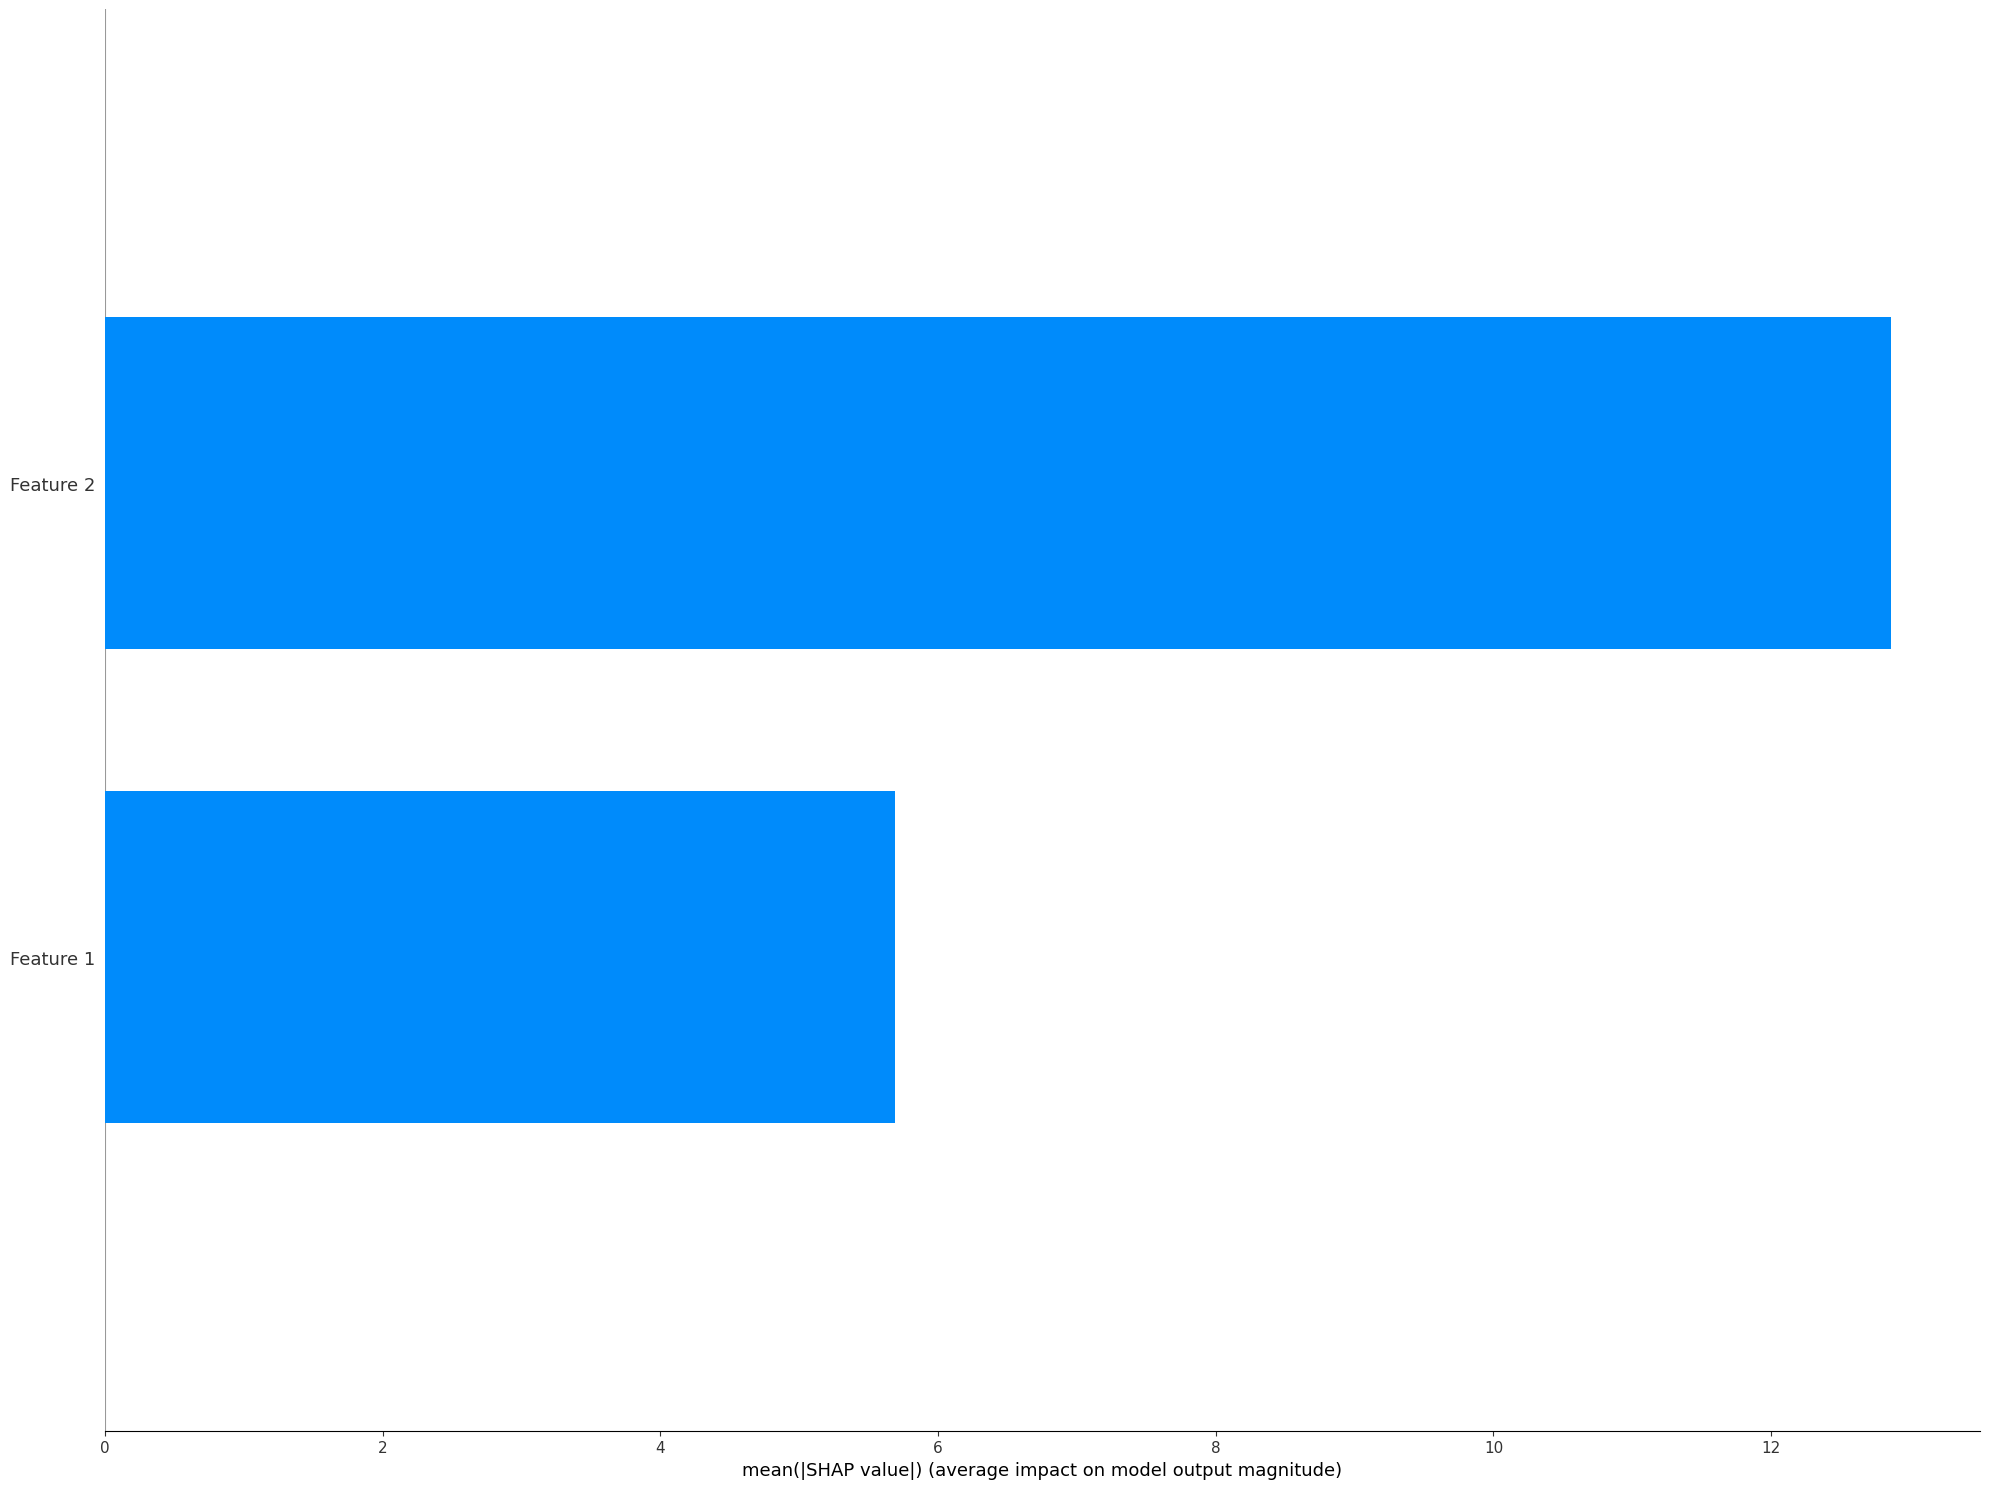

In [ ]:
features = ["Feature 1", "Feature 2"]
shap.summary_plot(shap_values, testData,feature_names = features,plot_type="bar",plot_size=(20,15),show=False)